# Camera calibration


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

Als erstes werden diverse Fotos vom checkerboard erstellt um die Kamera kalibrieren. Folgend ein Beispielbild:
![images/IMG_0441.jpeg](images/IMG_0441.jpeg)


Load all images


In [2]:
images = glob.glob('images/*.jpeg')

Prepare object point and some other stuff.


In [4]:
cbrow = 9
cbcol = 7

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((cbrow*cbcol,3), np.float32)
objp[:,:2] = np.mgrid[0:cbcol,0:cbrow].T.reshape(-1,2)

objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

In [5]:
# Code from Moodle
def findCorners(gray_, img_, fname_):
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray_, (cbcol,cbrow),None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray_,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        img_ = cv2.drawChessboardCorners(img_, (cbcol,cbrow), corners2,ret)    

Find for all images corners


In [6]:
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    findCorners(gray, img, fname)

Create a list. Each element in the list has one more image to calibrate. It is assumed that the values converge when several images are used.


In [7]:
matrix_list = []
distortion_list = []

In [8]:
for i in range(1, len(imgpoints)):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints[0:i], imgpoints[0:i], gray.shape[::-1],None,None)
    matrix_list.append(mtx)
    distortion_list.append(dist)

Printout of the last values:


In [10]:
print(matrix_list[-1])
print(distortion_list[-1])

[[5.50415186e+03 0.00000000e+00 2.00118905e+03]
 [0.00000000e+00 5.55914179e+03 1.90084044e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 4.64440277e-02 -4.81267406e-02  9.52628630e-03  4.25484520e-04
   1.14490815e+00]]


Plot all elements from the list:


In [11]:
fx_list = []
fy_list = []
cx_list = []
cy_list = []

for matrix in matrix_list:
    fx_list.append(matrix[0][0])
    fy_list.append(matrix[1][1])
    cx_list.append(matrix[0][2])
    cy_list.append(matrix[1][2])

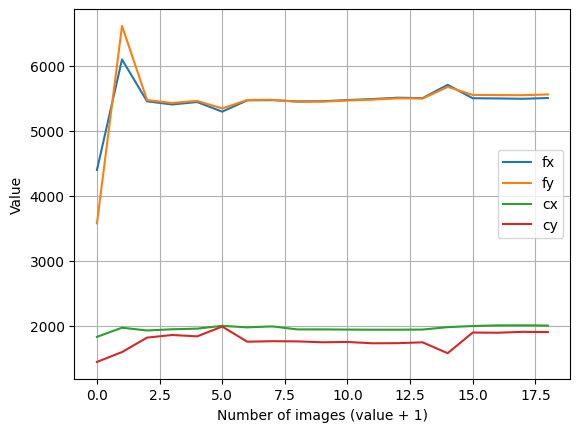

In [15]:
plt.plot(fx_list, label= "fx")
plt.plot(fy_list, label= "fy")

plt.plot(cx_list, label= "cx")
plt.plot(cy_list, label= "cy")

plt.xlabel("Number of images (value + 1)")
plt.ylabel("Value")

plt.grid()
plt.legend()

You can clearly see that the values converge as expected the more images are used for the calibration.


### Difference between focal length

The influence of the focal length on the translation vector was analysed. As expected, only one value in the vector changes when the focal length is increased by a factor of 1000. Der Verwendete Code ist `3_Tracker.py`.


Original focal length $\rightarrow \vec t \begin{bmatrix} -0.397 \\-0.474 \\ 2.12 \end{bmatrix}$ und $\vec r \begin{bmatrix} 0.558 \\-2.57 \\ 1.53 \end{bmatrix}$


Focal length \* 1000 $\rightarrow \vec t \begin{bmatrix} -0.392 \\-4.51 \\ 2.168 \end{bmatrix}$ und $\vec r \begin{bmatrix} 0.620 \\-2.22 \\ 1.65 \end{bmatrix}$


## Measure distance between two markers


The first calibration images were taken with the mobile phone in photo mode. When the mobile phone is used as a webcam, the image appears to be cropped. a new calibration was therefore created because a video stream was used.

$camera \space matrix = \begin{bmatrix} 
1209 & 0 & 0 960.9 \\
0 & 1201.9 & 530.1 \\
0 & 0 & 1
 \end{bmatrix}$

To measure the distance between two markers, the two translations vectors are used. these are subtracted and the Euclidean distance is calculated:

```python
distance = np.linalg.norm(tvec[1]-tvec[0])
```

The same was also done for each individual axis. in addition, a line was drawn between the two markers.


![distance.png](distance.png)


The accuracy is very good. However, the mobile phone used has different cameras. The software changes the camera from a certain distance to the object and therefore the measurement is not always consistent. Attached is a video that demonstrates the distance measurement.


The code:


In [ ]:
import numpy as np
import cv2
import cv2.aruco as aruco

#create your marker using http://chev.me/arucogen/
markerssize = 0.1 #in m
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_100)

# open calibration
cv_file = cv2.FileStorage("calib.yaml", cv2.FILE_STORAGE_READ)
mtx = cv_file.getNode("camera_matrix").mat()
dist = cv_file.getNode("dist_coeff").mat()

#------------------ ARUCO TRACKER ---------------------------

# get webcam stream
cap = cv2.VideoCapture(0)

foc_x = 1209.0
foc_y = 1201.9
principle_x = 960.9
principle_y = 530.2

mtx = np.array([[foc_x, 0, principle_x],
                [0, foc_y, principle_y],
                [0, 0, 1]], dtype=np.float64)
dist = np.array([-0.028, -0.0522, 0.00586, -0.00086, 1.616], dtype=np.float64)

cv2.namedWindow("frame", cv2.WND_PROP_FULLSCREEN)
while (True):
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict)

    if np.all(ids != None):
        rvec, tvec ,_ = aruco.estimatePoseSingleMarkers(corners, markerssize, mtx, dist)

        length=0.1
        thickness=20

        for i in range(0, ids.size):
            axis = np.float32([[0,0,0],[length,0,0], [0,length,0], [0,0,length]]).reshape(-1,3)
            imgpts, jac= cv2.projectPoints(axis, rvec[i], tvec[i], mtx, dist)
            imgpts = np.int32(imgpts).reshape(-1,2)

            

            #print("Marker "+str(ids[i][0])+" tvec: "+str(tvec[i])+" rvec: "+str(rvec[i]))

            aruco.drawDetectedMarkers(frame, corners)

            cv2.line(frame, tuple(imgpts[0].ravel()), tuple(imgpts[1].ravel()), (0, 0, 255), thickness);
            cv2.line(frame, tuple(imgpts[0].ravel()), tuple(imgpts[2].ravel()), (0, 255, 0), thickness);
            cv2.line(frame, tuple(imgpts[0].ravel()), tuple(imgpts[3].ravel()), (255, 0, 0), thickness);

            cv2.imshow('frame',frame)

        if ids.size > 1:
            color = (255, 0, 255)

            x_distance = tvec[0][0][0] - tvec[1][0][0]
            y_distance = tvec[0][0][1] - tvec[1][0][1]
            z_distance = tvec[0][0][2] - tvec[1][0][2]
            distance = np.linalg.norm(tvec[1]-tvec[0])
            cv2.putText(frame, f"{str("Distance:"):<10} {distance:>5.2f}m", (20,128), cv2.FONT_HERSHEY_SIMPLEX, 1, color,2,cv2.LINE_AA)
            cv2.putText(frame, f"{str("x:"):<10} {x_distance:>5.2f}m", (20,128+45), cv2.FONT_HERSHEY_SIMPLEX, 1, color,2,cv2.LINE_AA)
            cv2.putText(frame, f"{str("y:"):<10} {y_distance:>5.2f}m", (20,128+90), cv2.FONT_HERSHEY_SIMPLEX, 1, color,2,cv2.LINE_AA)
            cv2.putText(frame, f"{str("z:"):<10} {z_distance:>5.2f}m", (20,128+135), cv2.FONT_HERSHEY_SIMPLEX, 1, color,2,cv2.LINE_AA)

            color = (0, 0, 0)
            imgpts1, jac= cv2.projectPoints(axis, rvec[0], tvec[0], mtx, dist)
            imgpts1 = np.int32(imgpts1).reshape(-1,2)
            imgpts2, jac= cv2.projectPoints(axis, rvec[1], tvec[1], mtx, dist)
            imgpts2 = np.int32(imgpts2).reshape(-1,2)
            cv2.line(frame, tuple(imgpts1[0].ravel()), tuple(imgpts2[0].ravel()), color, int(thickness/2))
            center1 = imgpts1[0].ravel()
            center2 = imgpts2[0].ravel()
            text = f"d = {distance:.2f}m"
 
            text_position_x = center1[0]+20 + (center2[0]-center1[0])//2
            text_position_y = center1[1] + (center2[1]-center1[1])//2
            text_position = tuple([text_position_x, text_position_y])
            cv2.putText(frame, text, text_position, cv2.FONT_HERSHEY_SIMPLEX, 1, color,2,cv2.LINE_AA)

        strg = ''
        for i in range(0, ids.size):
            strg += str(ids[i][0])+' '

        cv2.putText(frame, "Id(s): " + strg, (20,64), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),2,cv2.LINE_AA)

    else:
        cv2.putText(frame, "No Ids", (0,64), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),2,cv2.LINE_AA)

    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# release
cap.release()
cv2.destroyAllWindows()